## Carga del dataset

In [ ]:
import pandas as pd
import numpy as np
import os, sys, shutil

# Load original state data

In [ ]:
!wget https://storage.googleapis.com/diabetic-detection/data_downscaled.zip
!unzip -o -q data_downscaled
!mv .tmp original

--2020-11-23 15:47:41--  https://storage.googleapis.com/diabetic-detection/data_downscaled.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 990385145 (945M) [application/zip]
Saving to: ‘data_downscaled.zip’

data_downscaled.zip 100%[===================>] 944.50M  66.2MB/s    in 16s     

2020-11-23 15:47:59 (60.7 MB/s) - ‘data_downscaled.zip’ saved [990385145/990385145]



In [ ]:
!mkdir data
!mkdir data/original

In [ ]:
!mv /content/original/raw_dataset_extracted_downscaled /content/data/original

In [ ]:
!mkdir /content/data/dataframes && mv /content/data/original/raw_dataset_extracted_downscaled/trainLabels.csv /content/data/dataframes

In [ ]:
labels = pd.read_csv('data/dataframes/trainLabels.csv')
valuesWithE = labels.loc[labels['level'] >= 1]
valuesNeutral = labels.loc[labels['level'] == 0]

print(len(valuesNeutral))
print(len(valuesWithE))

sampledNeutral = valuesNeutral.sample(len(valuesWithE), random_state=44)
print(len(sampledNeutral))

sampled = pd.concat([valuesWithE, sampledNeutral])
sampled = sampled.sample(frac=1).reset_index(drop=True)
print(len(sampled))

25810
9316
9316
18632


In [ ]:
!rm -rf resampled
!mkdir resampled
!mkdir resampled/original
!mkdir resampled/preprocessed

In [ ]:
def create_directory_flow(df, subset_name, base, dest, imageType):
  k = 0
  for _, row in df.iterrows():
    item = row.image
    level = row['level']
    basedir = base
    destDir = dest
    ext = '.jpeg'
    k = k+1
    orig_file = os.path.join(basedir, item + ext)
    if level == 0:
      os.makedirs(os.path.join(destDir, subset_name, 'No DR'), exist_ok=True)
      dest_file = os.path.join(destDir, subset_name, 'No DR', item +str(k) + ext)
      shutil.copy(orig_file, dest_file)
    else:
      os.makedirs(os.path.join(destDir, subset_name, 'DR'), exist_ok=True)
      dest_file = os.path.join(destDir, subset_name, 'DR', item +str(k) + ext)
      shutil.copy(orig_file, dest_file)

In [ ]:
# Copy resampled original
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split
train, test = train_test_split(sampled, train_size = 0.8, random_state=44, stratify=sampled.level)
test, val = train_test_split(test, test_size=0.5, random_state=44, stratify=test.level)

create_directory_flow(train,
                      'train',
                      'data/original/raw_dataset_extracted_downscaled/train',
                      'resampled/original',
                      'left')

create_directory_flow(val,
                      'validation',
                      'data/original/raw_dataset_extracted_downscaled/train',
                      'resampled/original',
                      'left')

create_directory_flow(test,
                      'test',
                      'data/original/raw_dataset_extracted_downscaled/train',
                      'resampled/original',
                      'left')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input

import cv2

img_shape = (224, 224)
train_path = os.path.join('/content/resampled', 'original', 'train')
validation_path = os.path.join('/content/resampled','original', 'validation')
test_path = os.path.join('/content/resampled','original', 'test')

# Reescalamos todas las imágenes en un factor de 1./255
train_datagen = ImageDataGenerator(
    rescale=1/255,
    horizontal_flip=True,
    vertical_flip=True,
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# La función flow_from_directory() toma el path a un directorio
# y genera batches de data a la que aplica las transformaciones definidas
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=img_shape,
        batch_size=128,
        class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
        validation_path,
        target_size=img_shape,
        batch_size=128,
        shuffle=False,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=img_shape,
        batch_size=128,
        shuffle=False,
        class_mode='binary')

Found 14905 images belonging to 2 classes.
Found 1864 images belonging to 2 classes.
Found 1863 images belonging to 2 classes.


In [ ]:
train_generator.class_indices

{'DR': 0, 'No DR': 1}

In [ ]:
len(train_generator.classes)

14905

In [ ]:
def attention(bn, pt_depth):
  attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(bn)
  attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
  attn_layer = LocallyConnected2D(1, kernel_size = (1,1), padding = 'valid', activation = 'sigmoid')(attn_layer)
  up_c2_w = np.ones((1, 1, 1, pt_depth))
  up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', activation = 'linear', use_bias = False, weights = [up_c2_w])
  up_c2.trainable = False
  attn_layer = up_c2(attn_layer)
  mask_features = multiply([attn_layer, bn])
  gap_features = GlobalAveragePooling2D()(mask_features)
  gap_mask = GlobalAveragePooling2D()(attn_layer)
  return Lambda(lambda x: x[0]/x[1])([gap_features, gap_mask])


In [317]:
from tensorflow.keras.applications import InceptionV3

from tensorflow.keras.models import Model

from tensorflow.keras.layers import BatchNormalization, LocallyConnected2D
from tensorflow.keras.layers import Flatten, Input, Conv2D, multiply
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.layers import Lambda, GlobalMaxPooling2D, Concatenate, MaxPooling2D

(w, h) = img_shape
input_shape = [w, h, 3]

input_layer = Input(input_shape)
inception = InceptionV3(input_shape=input_shape,
                                          include_top = False,
                                          weights='imagenet')

x = inception(input_layer)

x = Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv1')(x)
x = Conv2D(128, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block1_conv2')(x)
pt_features = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

pt_features1 = GlobalAveragePooling2D()(pt_features)
pt_features2 = GlobalMaxPooling2D()(pt_features)
pt_features3 = attention(pt_features, 128)

pt_features = Concatenate()([pt_features1, pt_features2, pt_features3])

pt_features = Dense(128, activation = "relu")(pt_features)
classification_layer = Dense(1, activation = "sigmoid")(pt_features)

retina_model = Model(inputs=[input_layer], outputs=[classification_layer])


In [318]:
retina_model.summary()

Model: "functional_82"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_115 (InputLayer)          [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
inception_v3 (Functional)       (None, 5, 5, 2048)   21802784    input_115[0][0]                  
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 5, 5, 128)    2359424     inception_v3[0][0]               
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 5, 5, 128)    147584      block1_conv1[0][0]               
______________________________________________________________________________________

In [319]:
len(inception.layers)

311

In [320]:
for layer in inception.layers[:200]:
    layer.trainable = False
for layer in inception.layers[200:]:
    layer.trainable = True

In [321]:
retina_model.summary()

Model: "functional_82"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_115 (InputLayer)          [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
inception_v3 (Functional)       (None, 5, 5, 2048)   21802784    input_115[0][0]                  
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 5, 5, 128)    2359424     inception_v3[0][0]               
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 5, 5, 128)    147584      block1_conv1[0][0]               
______________________________________________________________________________________

In [322]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import optimizers

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.8,
                                   patience=3,
                                   verbose=1,
                                   mode='auto',
                                   epsilon=0.0001,
                                   cooldown=5,
                                   min_lr=0.0001)

retina_model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(),
    metrics=['accuracy']
)

In [323]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=4,
    verbose=1,
    mode="auto",
    restore_best_weights=True,
)

In [324]:
history = retina_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=130,
    callbacks=[reduceLROnPlat, early_stopping],
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
)

Epoch 1/130
117/117 [==============================] - 65s 551ms/step - loss: 0.6257 - accuracy: 0.6780 - val_loss: 0.9217 - val_accuracy: 0.6770
Epoch 2/130
117/117 [==============================] - 63s 536ms/step - loss: 0.4837 - accuracy: 0.7550 - val_loss: 0.7395 - val_accuracy: 0.7312
Epoch 3/130
117/117 [==============================] - 63s 535ms/step - loss: 0.4586 - accuracy: 0.7754 - val_loss: 0.4790 - val_accuracy: 0.7682
Epoch 4/130
117/117 [==============================] - 63s 538ms/step - loss: 0.4420 - accuracy: 0.7869 - val_loss: 0.4640 - val_accuracy: 0.7741
Epoch 5/130
117/117 [==============================] - 63s 537ms/step - loss: 0.4290 - accuracy: 0.7968 - val_loss: 0.4716 - val_accuracy: 0.7613
Epoch 6/130
117/117 [==============================] - 63s 537ms/step - loss: 0.4252 - accuracy: 0.7973 - val_loss: 0.5611 - val_accuracy: 0.7436
Epoch 7/130
117/117 [==============================] - 63s 539ms/step - loss: 0.4070 - accuracy: 0.8072 - val_loss: 0.4413 -

In [330]:
retina_model.save('inception_resnet.h5')

In [335]:
import sklearn.metrics as metrics

def predictAndEvaluate(model_):
  y_pred = model_.predict(test_generator,steps=100)
  from sklearn.metrics import classification_report
  y_pred1 =y_pred.copy()
  y_pred1[y_pred1>=0.5] = 1
  y_pred1[y_pred1<0.5] = 0
  y_pred1=y_pred1.astype(int)

  print(classification_report(test_generator.classes, y_pred1))
  from sklearn.metrics import balanced_accuracy_score
  print(balanced_accuracy_score(test_generator.classes, y_pred1))
  print('CM: ')
  confusion_matrix = metrics.confusion_matrix(y_true=test_generator.classes, y_pred=y_pred1)  # shape=(12, 12)
  print(confusion_matrix)

In [336]:
predictAndEvaluate(retina_model)

              precision    recall  f1-score   support

           0       0.84      0.70      0.77       932
           1       0.75      0.87      0.80       931

    accuracy                           0.79      1863
   macro avg       0.79      0.79      0.79      1863
weighted avg       0.79      0.79      0.79      1863

0.786946865938605
CM: 
[[657 275]
 [122 809]]


In [331]:
import matplotlib.pyplot as plt
def plotHistory(history_):
  plt.plot(history_.history['accuracy'])
  plt.plot(history_.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  plt.plot(history_.history['loss'])
  plt.plot(history_.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

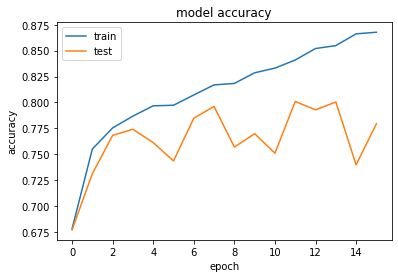

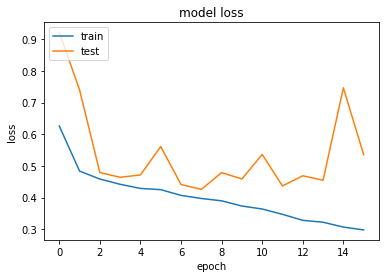

In [332]:
plotHistory(history)